In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import numba
from numba import njit,jit
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [3]:
a = sciIO.readsav('../B0.sav')
print(a.keys())

C:\Users\Pjer1\Anaconda3\envs\torch15\lib\site-packages\scipy\io\idl.py:469: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


dict_keys(['twbox'])
time: 3.48 s


In [4]:
# need to be transposed because of the storage toplogy
Bx = np.transpose(a.twbox[0].bx,(2,1,0))
By = np.transpose(a.twbox[0].by,(2,1,0))
Bz = np.transpose(a.twbox[0].bz,(2,1,0))

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

time: 2 ms


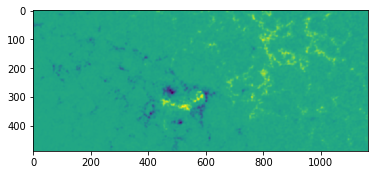

time: 244 ms


In [5]:
plt.imshow(Bz[350:670,200:400,0].T) # x,y.z
plt.imshow(Bz[:,:,0].T)

In [6]:
np.mean(np.abs((Bx)))

11.779769

time: 1.27 s


In [7]:
vec = np.array([1.01,2.01,5.01])
vec[vec<=0]=1e-9
vec[vec>=Bx.shape]=(np.array(Bx.shape)-1e-9)[vec>=Bx.shape]

time: 1e+03 µs


In [8]:
Bx_gpu.shape

(0,)

time: 2 ms


In [44]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy

traceFunc_file = open("TraceBline.cu", "rt")
traceFunc =SourceModule(traceFunc_file.read())
print('compiling kernel')
TraceAllBline = traceFunc.get_function("TraceAllBline")

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = gpuarray.to_gpu(Bx.astype(np.float32))
    By_gpu = gpuarray.to_gpu(By.astype(np.float32))
    Bz_gpu = gpuarray.to_gpu(Bz.astype(np.float32))

compiling kernel
time: 7.87 s


<ipython-input-44-209e963f3392>:7: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  traceFunc =SourceModule(traceFunc_file.read())


In [45]:
# shape of B
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape

interp_ratio=4
x_range = [0,1163]
y_range = [0,487]
#x_range = [350,670]
#y_range = [200,400]
#x_range = [587,588]
#y_range = [301,302]
x_i = np.linspace(*x_range, np.uint32(interp_ratio*(x_range[1]-x_range[0])))
y_i = np.linspace(*y_range, np.uint32(interp_ratio*(y_range[1]-y_range[0])))
x_arr,y_arr = np.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten().astype(np.float32)
y_inp = y_arr.flatten().astype(np.float32)
z_inp = np.zeros_like(x_inp).astype(np.float32)

#z_inp[:] = 23.0

x_out = np.zeros_like(x_inp).astype(np.float32)
y_out = np.zeros_like(x_inp).astype(np.float32)
z_out = np.zeros_like(x_inp).astype(np.float32)

Bx_out = np.zeros_like(x_inp).astype(np.float32)
By_out = np.zeros_like(x_inp).astype(np.float32)
Bz_out = np.zeros_like(x_inp).astype(np.float32)

Bx_inp = np.zeros_like(x_inp).astype(np.float32)
By_inp = np.zeros_like(x_inp).astype(np.float32)
Bz_inp = np.zeros_like(x_inp).astype(np.float32)

flag_out = np.zeros_like(x_inp).astype(np.int32)
step_line_len = np.zeros_like(x_inp).astype(np.ulonglong)

s_len = np.float32([0.25])
N=np.ulonglong([x_inp.shape[0]])

# for GTX 1060
#blck=(32,1,1)
#grd = (80,1)


blck=(128,1,1)
grd = (56,1)

# chuck everything

time: 943 ms


In [46]:
y_arr.shape

(1948, 4652)

time: 2.99 ms


In [47]:
BshapeN

array([1164,  488,  488])

time: 2.96 ms


In [48]:
BshapeN = gpuarray.to_gpu(BshapeN)
x_inp = gpuarray.to_gpu(x_inp)
y_inp = gpuarray.to_gpu(y_inp)
z_inp = gpuarray.to_gpu(z_inp)

x_out = gpuarray.to_gpu(x_out)
y_out = gpuarray.to_gpu(y_out)
z_out = gpuarray.to_gpu(z_out)

s_len    = gpuarray.to_gpu(s_len)
flag_out = gpuarray.to_gpu(flag_out)
N        = gpuarray.to_gpu(N)


Bx_out = gpuarray.to_gpu(Bx_out)
By_out = gpuarray.to_gpu(By_out)
Bz_out = gpuarray.to_gpu(Bz_out)

Bx_inp = gpuarray.to_gpu(Bx_inp)
By_inp = gpuarray.to_gpu(By_inp)
Bz_inp = gpuarray.to_gpu(Bz_inp)

step_line_len = gpuarray.to_gpu(step_line_len)


time: 329 ms


In [49]:
TraceAllBline(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
             x_inp,y_inp,z_inp,
             x_out,y_out,z_out,
             s_len,
             Bx_inp,By_inp,Bz_inp,
             Bx_out,By_out,Bz_out,
             flag_out,N,step_line_len,
             block=blck,grid=grd)

pycuda.driver.Context.synchronize()

time: 38 s


In [50]:
flag_out.get()

array([42, 42,  1, ..., 42, 42, 42])

time: 85 ms


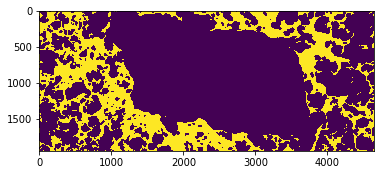

time: 429 ms


In [51]:
plt.imshow(flag_out.get().reshape(xy_shape),vmax=3)

(array([      0.,       0., 6716633.,       0.]),
 array([-1.,  0.,  1.,  2.,  3.]),
 <a list of 4 Patch objects>)

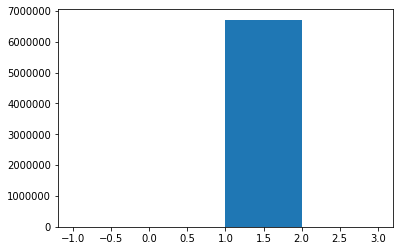

time: 365 ms


In [52]:
plt.hist(flag_out.get(),np.linspace(-1,3,5))

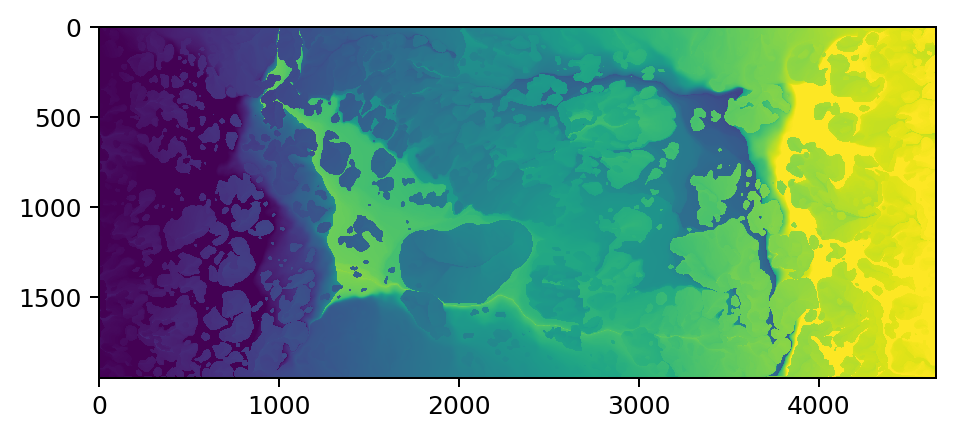

time: 611 ms


In [53]:
plt.figure(dpi=180)
plt.imshow(x_out.get().reshape(xy_shape))

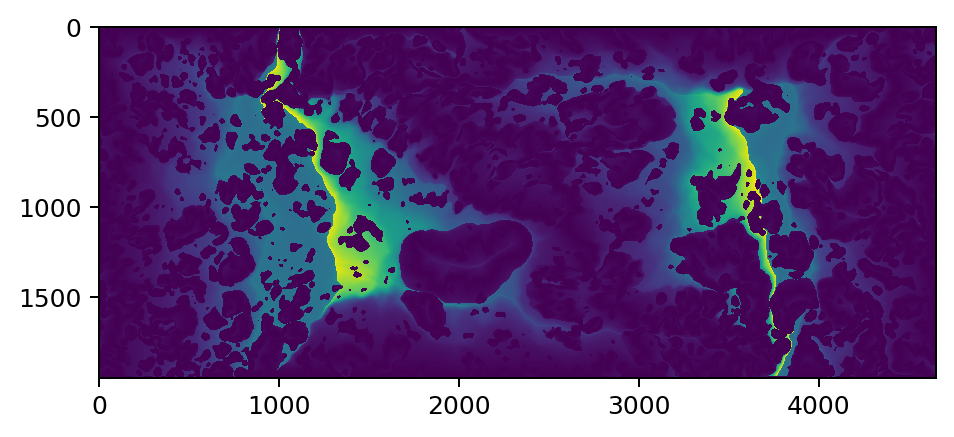

time: 722 ms


In [54]:
plt.figure(dpi=180)
plt.imshow(step_line_len.get().reshape(xy_shape))

In [58]:
#from mpl_toolkits import mplot3d

#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.plot(xx,yy,zz)

time: 1e+03 µs


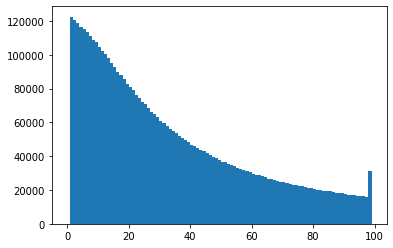

time: 625 ms


In [59]:
histlen=plt.hist(step_line_len.get(),bins=np.arange(100))

In [60]:
starting_point = np.array([400.5,250.5,0.0]).astype(np.float32)
ending_point = np.array([400.5,250.5,0.0]).astype(np.float32)
xx = np.zeros(1000).astype(np.float32)
yy = np.zeros(1000).astype(np.float32)
zz = np.zeros(1000).astype(np.float32)

starting_point = gpuarray.to_gpu(starting_point)
ending_point = gpuarray.to_gpu(ending_point)
xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)
zz = gpuarray.to_gpu(zz)

pycuda.driver.Context.synchronize()

TraceBline_test(Bx_gpu,By_gpu,Bz_gpu,BshapeN,
             starting_point,ending_point,
             s_len,flag_out,N,step_line_len,
             xx,yy,zz,
             block=(1,1,1))

NameError: name 'TraceBline_test' is not defined

time: 13 ms


In [61]:
x_end_arr = x_out.get().reshape(xy_shape)
y_end_arr = y_out.get().reshape(xy_shape)
flags_arr = flag_out.get().reshape(xy_shape)
Bz_arr_in = Bz_inp.get().reshape(xy_shape)


time: 137 ms


In [62]:
a = (x_end_arr[2:,1:-1]-x_end_arr[0:-2,1:-1])/2
b = (x_end_arr[1:-1,2:]-x_end_arr[1:-1,0:-2])/2
c = (y_end_arr[2:,1:-1]-y_end_arr[0:-2,1:-1])/2
d = (y_end_arr[1:-1,2:]-y_end_arr[1:-1,0:-2])/2

time: 249 ms


In [63]:
Q = (a**2+b**2+c**2+d**2)/np.abs(a*d-c*b)

time: 359 ms


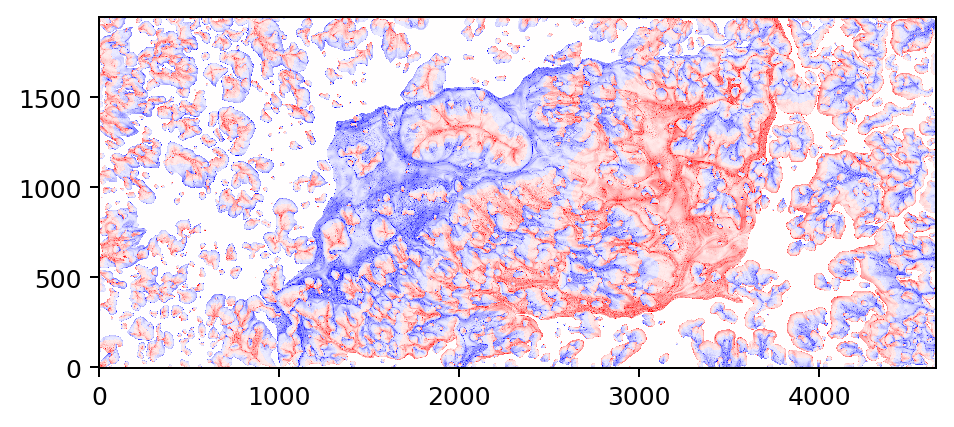

time: 961 ms


In [64]:

plt.figure(dpi=180)
plt.imshow(np.log10(Q)*(flags_arr[1:-1,1:-1]==1)*np.sign(-Bz_arr_in[1:-1,1:-1]),vmax=4,vmin=-4,cmap='bwr',origin='lower')

In [ ]:
plt.figure(dpi=180)
plt.imshow(a**2+b**2+c**2+d**2,vmax=10)

In [ ]:
plt.imshow(a*b-c*d,vmax=10,vmin=-10)

In [ ]:
np.arange(10)[0:-2]